# Want to see graph in all organs to see where the difference is the most significant

# I] Import

In [1]:
import pandas, seaborn, numpy
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(12, 8)})

## functions & options


In [2]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

## Data download and preparation

In [3]:
%%time
# DL data ATG7 isoform expression and High low expression separation
path = output_file_directory + "/ATG7/dataframes_for_input/"
df_ATG7_NormPrim= pandas.read_csv(path+'df_ATG7_NormPrim.csv', sep = ",")

#remove NaN value in OS column (will remove Normal Tissue).
df_ATG7_Prim = df_ATG7_NormPrim.dropna(axis=0)
print(df_ATG7_Prim.shape)
df_ATG7_Prim.head()

(9130, 22)
Wall time: 82.2 ms


,sample,Sample_Type,Primary_Site,OS,OS_time,ATG7,ATG7_1,ATG7_2,ATG7_3,ATG7_total,...,ATG7_3tpm,log2_p1_ATG7_total,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
7429,TCGA-OR-A5J2-01,Primary Tumor,Adrenal Gland,1.0,1677.0,4.824,3.239,1.903,1.258,28.323920,...,2.390640e+00,4.874006,3.384104,2.244552,15.569935,60.632203,24.013593,1.535420e+01,0.333301,0.132005
7430,TCGA-P6-A5OG-01,Primary Tumor,Adrenal Gland,1.0,383.0,4.790,4.056,1.151,-9.966,27.664191,...,-1.495113e-07,4.841178,4.140146,1.686916,18.851948,88.225740,11.774261,-7.930814e-07,0.601220,0.080236
7431,TCGA-OR-A5J8-01,Primary Tumor,Adrenal Gland,1.0,579.0,4.764,4.570,-1.639,-9.966,27.170080,...,-1.495113e-07,4.816092,4.629437,0.400624,24.071456,98.670297,1.329703,-6.211145e-07,0.874174,0.011781
7432,TCGA-OR-A5K5-01,Primary Tumor,Adrenal Gland,1.0,498.0,4.751,4.216,-2.727,-4.608,26.926343,...,4.000660e-02,4.803555,4.291540,0.201684,18.773186,98.987671,0.799224,2.131050e-01,0.690147,0.005572
7433,TCGA-PA-A5YG-01,Primary Tumor,Adrenal Gland,0.0,756.0,4.600,3.060,2.783,1.125,24.250465,...,2.180015e+00,4.658238,3.223226,2.978529,17.400563,47.922164,39.549417,1.252842e+01,0.343858,0.283781


In [4]:
tissue_labels = df_ATG7_Prim['Primary_Site'].value_counts()
tissue_labels = tissue_labels.reset_index()
tissue_labels = tissue_labels['index']

for i in range(len(tissue_labels)):
    tissue = tissue_labels[i]
    print(i, 'is', tissue)

0 is Breast
1 is Lung
2 is Kidney
3 is Brain
4 is Head And Neck Region
5 is Thyroid Gland
6 is Prostate
7 is Ovary
8 is Stomach
9 is Bladder
10 is Liver
11 is Cervix
12 is Colon
13 is Soft Tissue,Bone
14 is Esophagus
15 is Endometrium
16 is Pancreas
17 is Paraganglia
18 is Testis
19 is Thymus
20 is Skin
21 is Rectum
22 is Lining Of Body Cavities
23 is Eye
24 is Adrenal Gland
25 is Uterus
26 is Lymphatic Tissue
27 is Bile Duct


# II] Kaplan Meier graph & stats

## LOG2 TPM. SHOULD I USE TPM ?

In [5]:
#Kaplan Meier for all tissues 
# isoforms = [["ATG7_1", "iso1"], ["ATG7_2", "iso2"]]
# initialize list of lists + Create the pandas DataFrame
data_ba = [['ATG7'], ['ATG7_1'], ['ATG7_2'], ['ATG7_3']]
df_hazard_ratio = pandas.DataFrame(data_ba, columns = ['covariate'])

#create df_site for each primary site (tissue)
for i in range(len(tissue_labels)):
    tissue = tissue_labels[i]
#     print('For', tissue)

    text_site = 'Primary_Site == ' + "'" + tissue + "'"
    df_site = df_ATG7_Prim.query(text_site)
    
    # STATS CoxPHFitter: Does ATG7 expression affect survival ?
    cph = CoxPHFitter()
    df = df_site.iloc[:,3:9]
    cph.fit(df,'OS_time', 'OS') 
    hr = cph.hazard_ratios_
    
    #convert result to df, extract column and insert in the final df
    hr = hr.to_frame()
    hr = hr.reset_index()
    name_col = tissue
    col = hr.pop('exp(coef)')
    df_hazard_ratio.insert(1, name_col, col)

df_hazard_ratio = df_hazard_ratio.set_index('covariate')
df_hazard_ratio.index.name = None
df_hazard_ratio

,Bile Duct,Lymphatic Tissue,Uterus,Adrenal Gland,Eye,Lining Of Body Cavities,Rectum,Skin,Thymus,Testis,...,Bladder,Stomach,Ovary,Prostate,Thyroid Gland,Head And Neck Region,Brain,Kidney,Lung,Breast
ATG7,0.084061,0.440764,0.337373,0.984592,2.153407,1.227303,0.057797,2.712267,0.202424,0.412079,...,0.931738,0.928331,1.034990,1.073470,0.639777,1.128067,1.614445,1.089505,0.901147,1.490532
ATG7_1,5.381751,0.256700,2.253375,1.075960,0.498974,0.605280,9.112599,0.359982,74.684617,3.992969,...,1.038235,1.368940,0.916130,1.104564,2.354730,0.787585,1.157635,0.806841,1.078467,0.879673
ATG7_2,1.292778,0.848035,1.056493,0.992583,0.965281,1.021286,1.245897,0.897998,1.210660,1.645515,...,1.034278,0.955205,1.017701,0.994599,1.268946,0.966807,1.035661,0.963668,1.042764,1.017368
ATG7_3,1.069087,1.064489,1.043393,1.006400,0.930847,0.960431,1.062255,0.998944,1.217023,1.274997,...,1.022578,1.022511,1.006742,0.983644,1.023473,0.992756,0.994858,0.966802,1.012850,0.975116


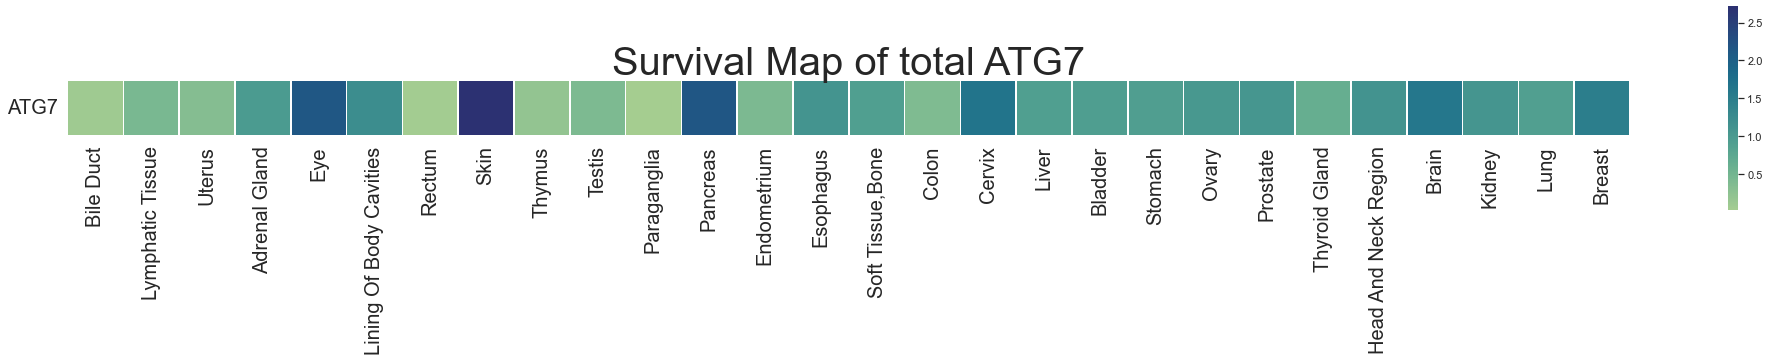

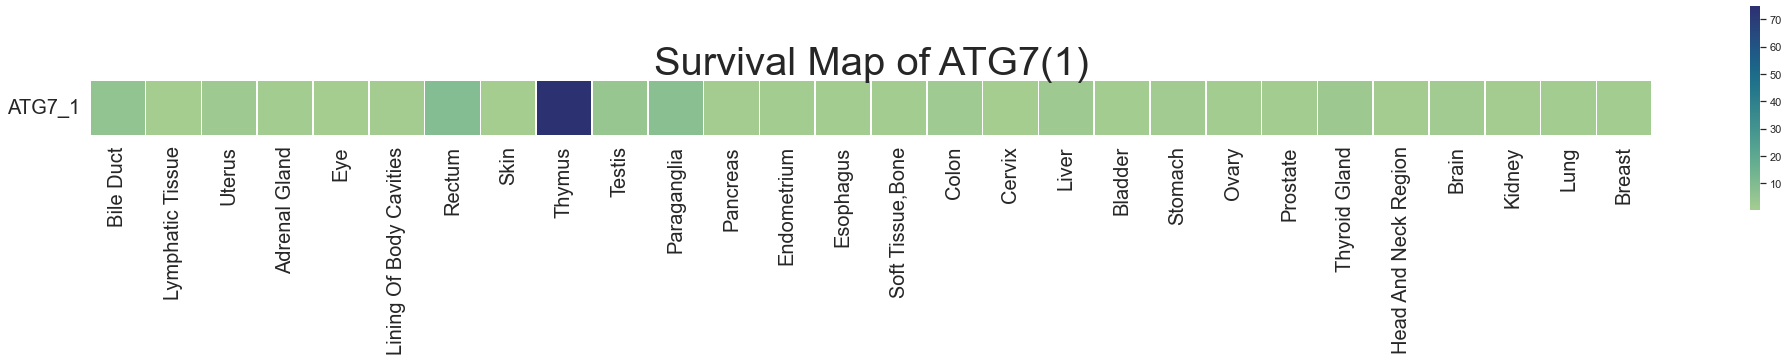

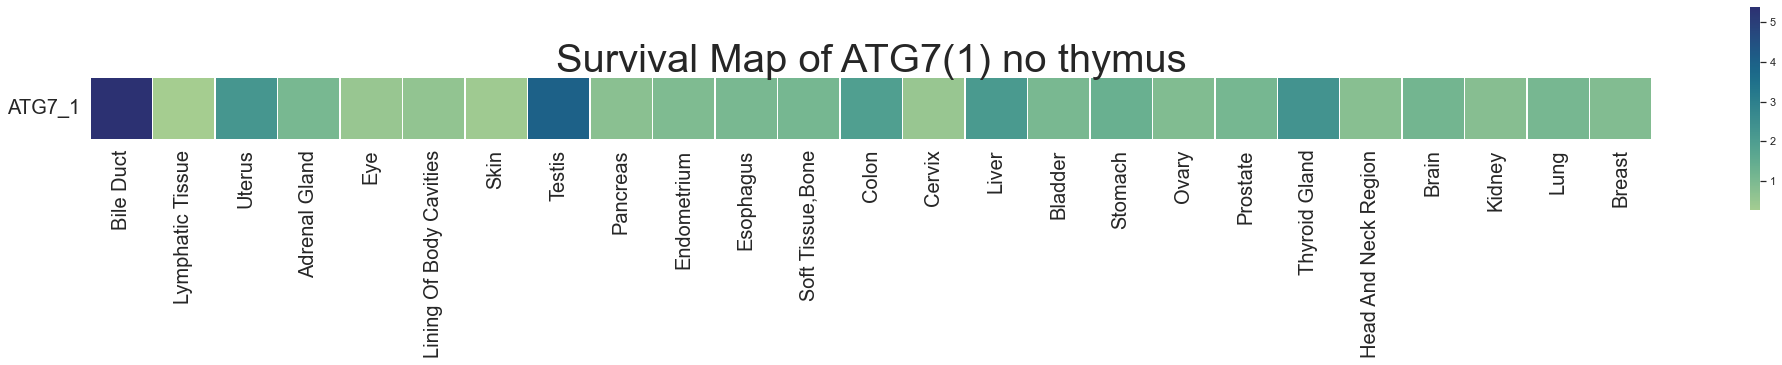

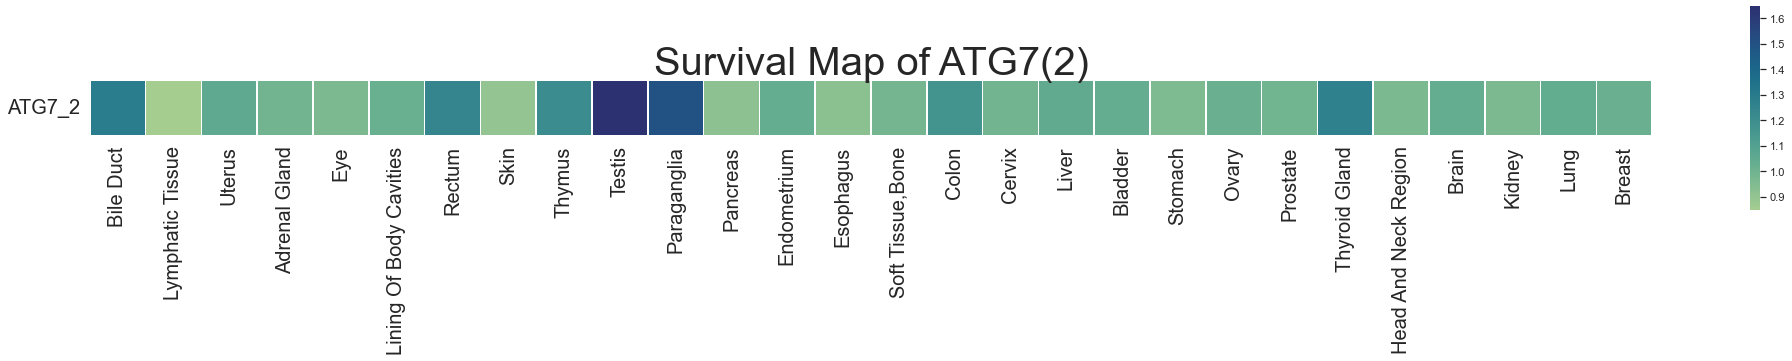

<Figure size 2520x792 with 0 Axes>

In [6]:
df_heatmap_T = df_hazard_ratio.iloc[0:1,]
df_heatmap_1 = df_hazard_ratio.iloc[1:2,]
df_heatmap_1b = df_heatmap_1.drop(['Thymus', 'Paraganglia', 'Rectum'],  axis = 1)
df_heatmap_2 = df_hazard_ratio.iloc[2:3,]

all_df = [[df_heatmap_T, 'total ATG7'], [df_heatmap_1, 'ATG7(1)'], 
          [df_heatmap_1b, 'ATG7(1) no thymus'], [df_heatmap_2, "ATG7(2)"]]

for df in all_df:
    # df_heatmap = df_heatmap.drop(['Thymus', 'Paraganglia', 'Rectum'],  axis = 1)
    seaborn.set(rc = {'figure.figsize':(35,11)})
    seaborn.heatmap(df[0], annot=False, cmap="crest", linewidths=.5, square= True, 
                    cbar_kws={'shrink': 0.34})
    plt.title('Survival Map of '+ df[1], fontsize=40)
    plt.yticks(fontsize=20, rotation = 0)
    plt.xticks(fontsize=20, rotation = 90)
    plt.show()
    plt.clf()

## Heatmap with Log10 like they did on Gepia2

In [8]:
df_hazard_ratio_log10 = df_hazard_ratio.apply(lambda col: numpy.log10(col))
df_hazard_ratio_log10

,Bile Duct,Lymphatic Tissue,Uterus,Adrenal Gland,Eye,Lining Of Body Cavities,Rectum,Skin,Thymus,Testis,...,Bladder,Stomach,Ovary,Prostate,Thyroid Gland,Head And Neck Region,Brain,Kidney,Lung,Breast
ATG7,-1.075403,-0.355793,-0.471890,-0.006744,0.333126,0.088952,-1.238098,0.433333,-0.693738,-0.385019,...,-0.030706,-0.032297,0.014936,0.030790,-0.193972,0.052335,0.208023,0.037229,-0.045204,0.173341
ATG7_1,0.730924,-0.590574,0.352834,0.031796,-0.301922,-0.218043,0.959642,-0.443720,1.873231,0.601296,...,0.016296,0.136385,-0.038043,0.043191,0.371941,-0.103702,0.063572,-0.093212,0.032807,-0.055679
ATG7_2,0.111524,-0.071586,0.023867,-0.003233,-0.015346,0.009147,0.095482,-0.046725,0.083022,0.216302,...,0.014637,-0.019903,0.007620,-0.002352,0.103443,-0.014660,0.015218,-0.016072,0.018186,0.007478
ATG7_3,0.029013,0.027141,0.018448,0.002771,-0.031122,-0.017534,0.026229,-0.000459,0.085299,0.105509,...,0.009696,0.009668,0.002918,-0.007162,0.010076,-0.003157,-0.002239,-0.014662,0.005545,-0.010944


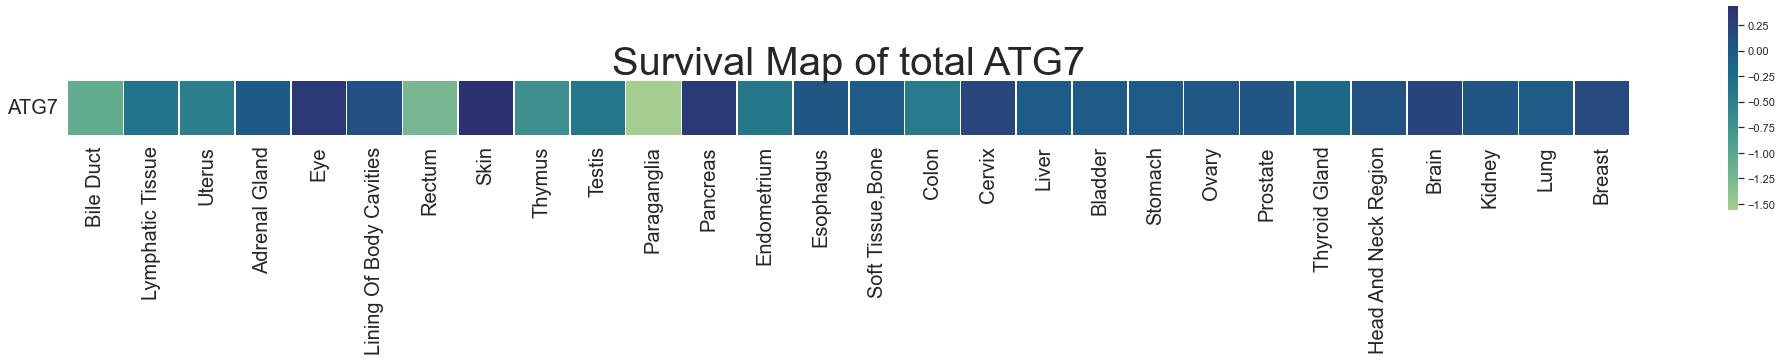

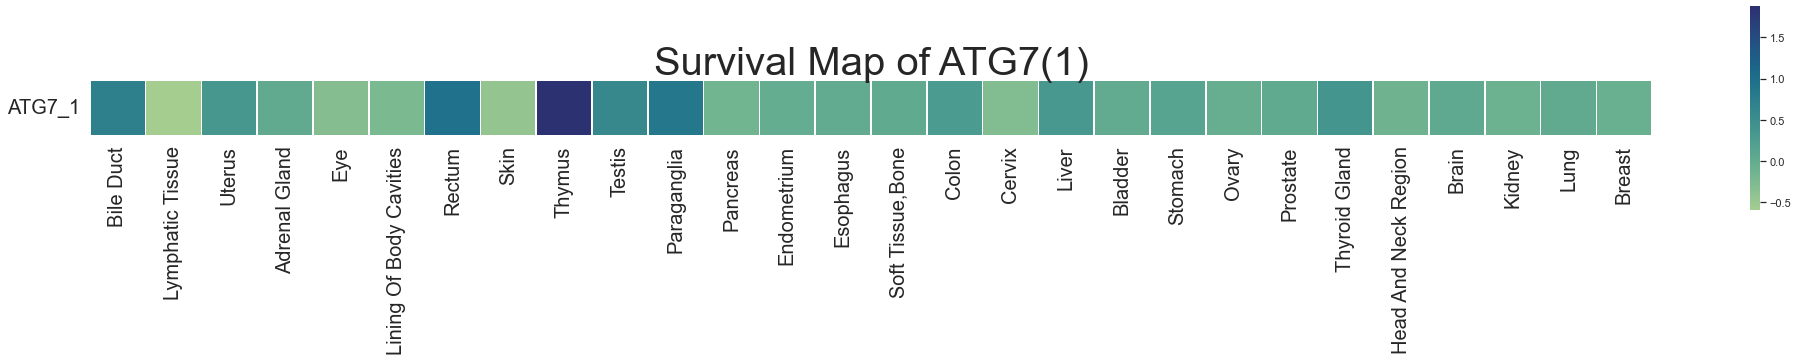

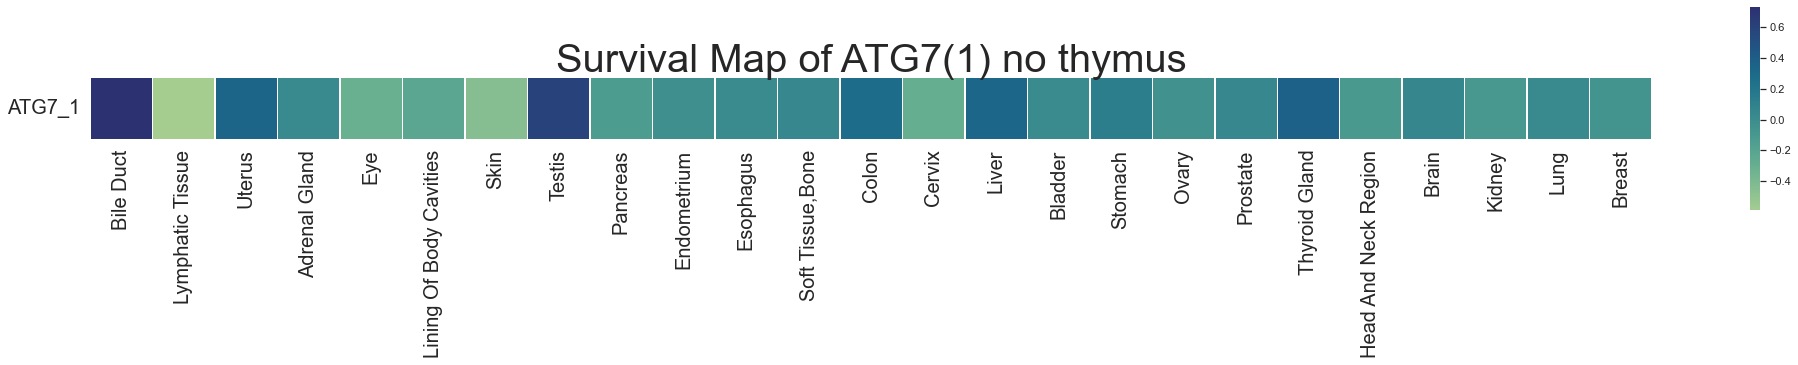

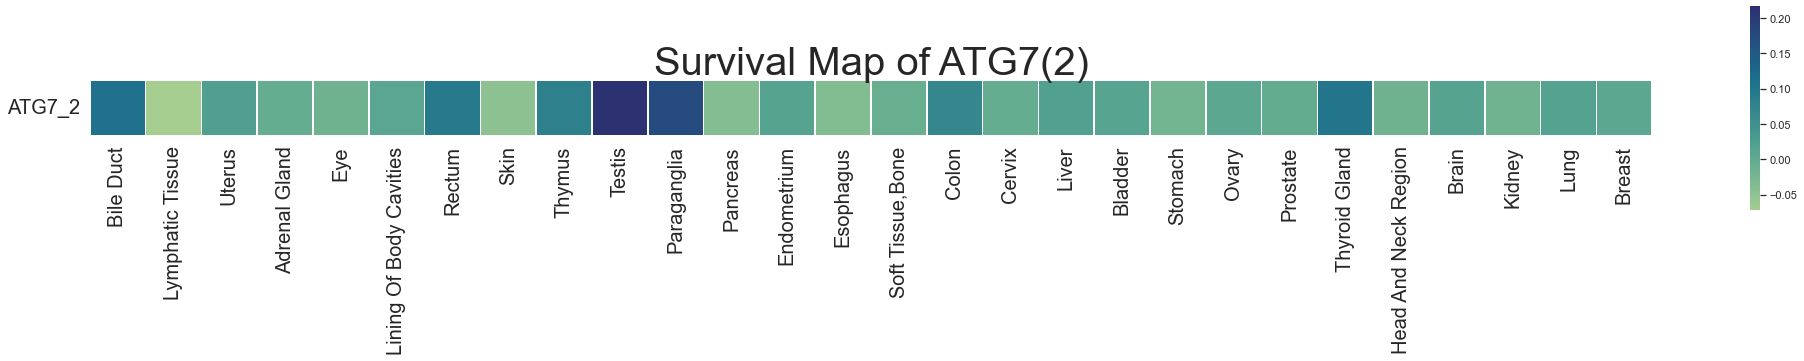

<Figure size 2520x792 with 0 Axes>

In [9]:
#LOG10 HR
df_heatmap_T = df_hazard_ratio_log10.iloc[0:1,]
df_heatmap_1 = df_hazard_ratio_log10.iloc[1:2,]
df_heatmap_1b = df_heatmap_1.drop(['Thymus', 'Paraganglia', 'Rectum'],  axis = 1)
df_heatmap_2 = df_hazard_ratio_log10.iloc[2:3,]

all_df = [[df_heatmap_T, 'total ATG7'], [df_heatmap_1, 'ATG7(1)'], 
          [df_heatmap_1b, 'ATG7(1) no thymus'], [df_heatmap_2, "ATG7(2)"]]

for df in all_df:
    # df_heatmap = df_heatmap.drop(['Thymus', 'Paraganglia', 'Rectum'],  axis = 1)
    seaborn.set(rc = {'figure.figsize':(35,11)})
    seaborn.heatmap(df[0], annot=False, cmap="crest", linewidths=.5, square= True, 
                    cbar_kws={'shrink': 0.34})
    plt.title('Survival Map of '+ df[1], fontsize=40)
    plt.yticks(fontsize=20, rotation = 0)
    plt.xticks(fontsize=20, rotation = 90)
    plt.show()
    plt.clf()

For explanation: 
Logrank_test(p) is pvalue of difference Low/High
HR(p) is pvalue of the effect of ATG7(x) expression in survival

## Graph + stats

For Breast
Results for  ATG7(total) in Breast


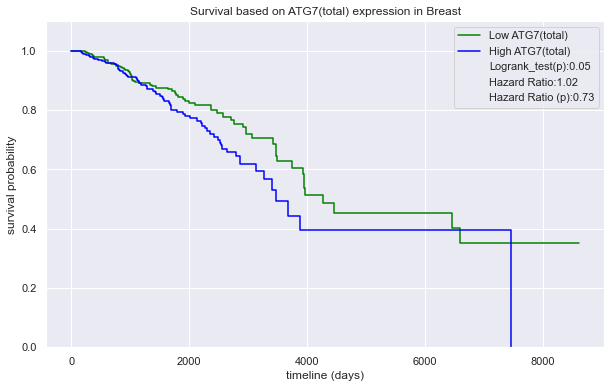

Results for  ATG7(1) in Breast


<Figure size 2520x792 with 0 Axes>

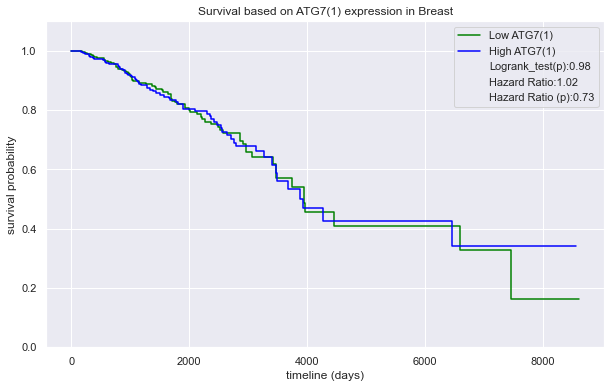

Results for  ATG7(2) in Breast


<Figure size 2520x792 with 0 Axes>

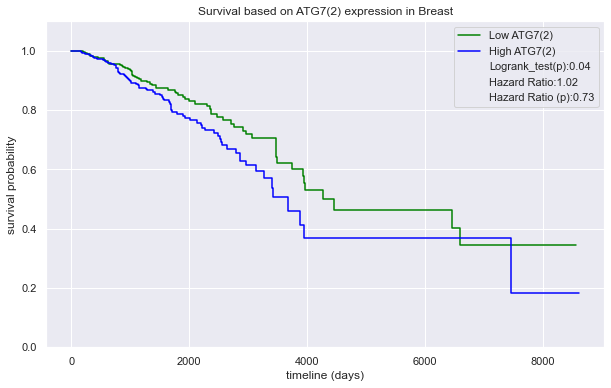

-------------------------------------------------------------------------

For Lung
Results for  ATG7(total) in Lung


<Figure size 2520x792 with 0 Axes>

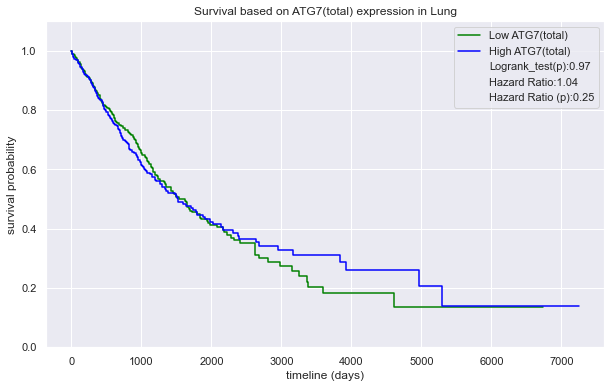

Results for  ATG7(1) in Lung


<Figure size 2520x792 with 0 Axes>

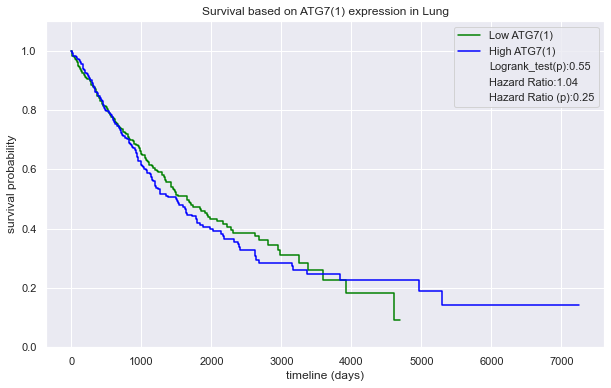

Results for  ATG7(2) in Lung


<Figure size 2520x792 with 0 Axes>

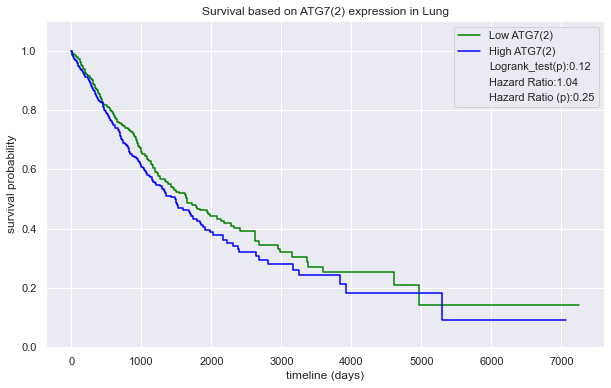

-------------------------------------------------------------------------

For Kidney
Results for  ATG7(total) in Kidney


<Figure size 2520x792 with 0 Axes>

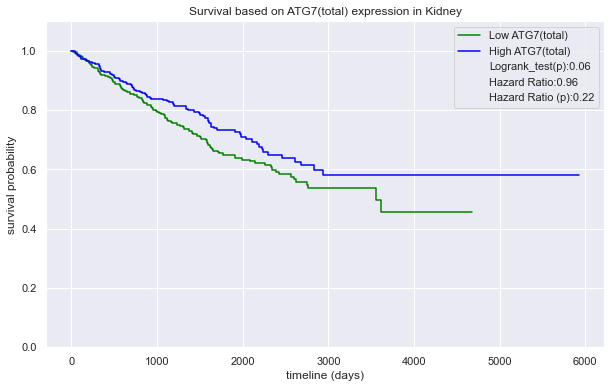

Results for  ATG7(1) in Kidney


<Figure size 2520x792 with 0 Axes>

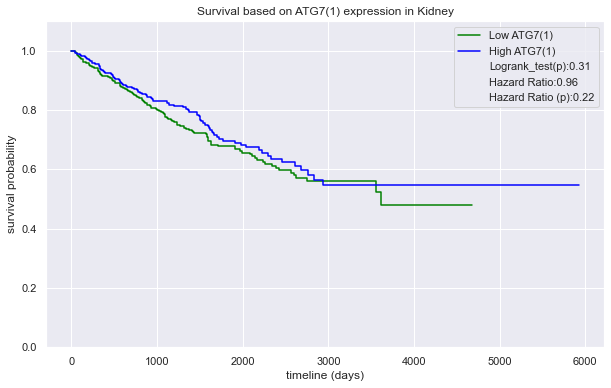

Results for  ATG7(2) in Kidney


<Figure size 2520x792 with 0 Axes>

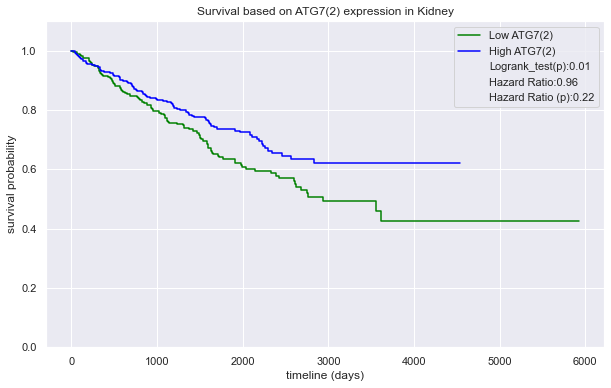

-------------------------------------------------------------------------

For Brain
Results for  ATG7(total) in Brain


<Figure size 2520x792 with 0 Axes>

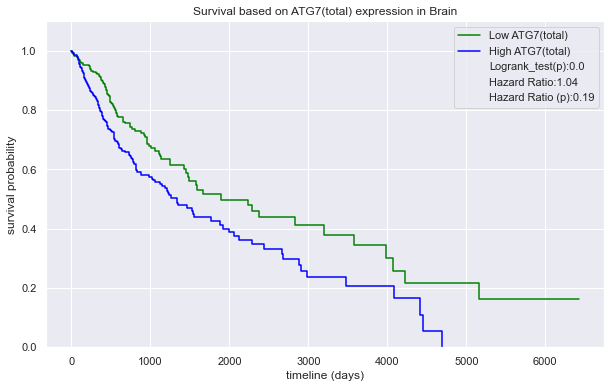

Results for  ATG7(1) in Brain


<Figure size 2520x792 with 0 Axes>

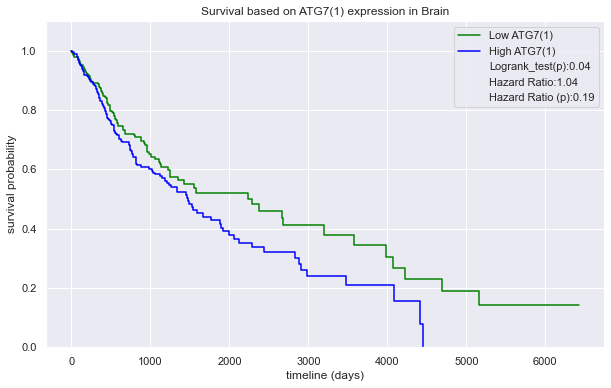

Results for  ATG7(2) in Brain


<Figure size 2520x792 with 0 Axes>

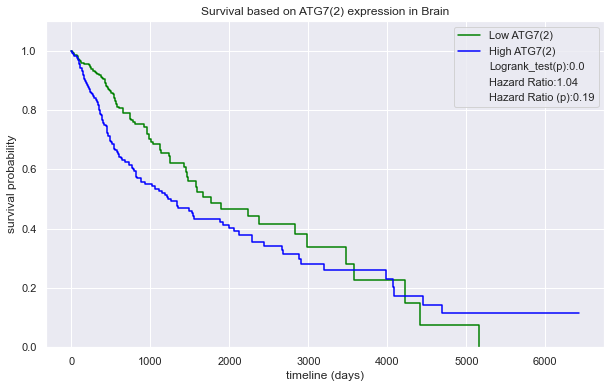

-------------------------------------------------------------------------

For Head And Neck Region
Results for  ATG7(total) in Head And Neck Region


<Figure size 2520x792 with 0 Axes>

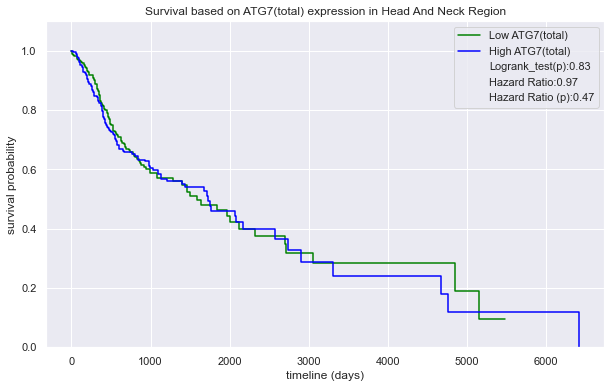

Results for  ATG7(1) in Head And Neck Region


<Figure size 2520x792 with 0 Axes>

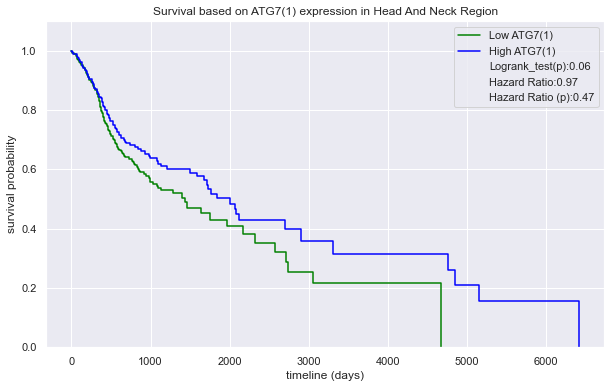

Results for  ATG7(2) in Head And Neck Region


<Figure size 2520x792 with 0 Axes>

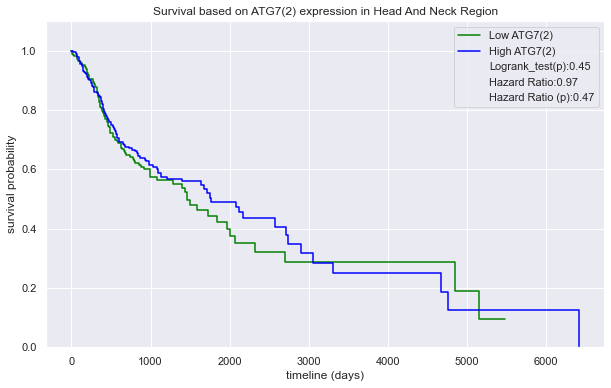

-------------------------------------------------------------------------

For Thyroid Gland
Results for  ATG7(total) in Thyroid Gland


<Figure size 2520x792 with 0 Axes>

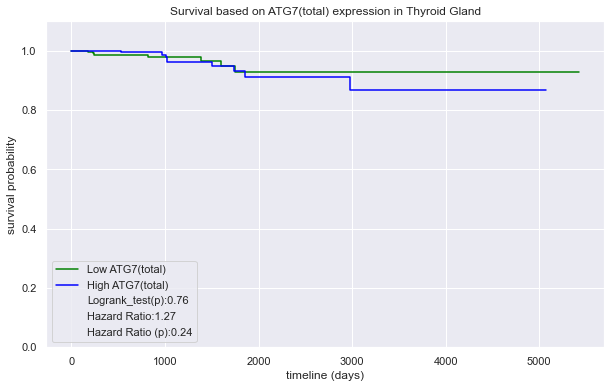

Results for  ATG7(1) in Thyroid Gland


<Figure size 2520x792 with 0 Axes>

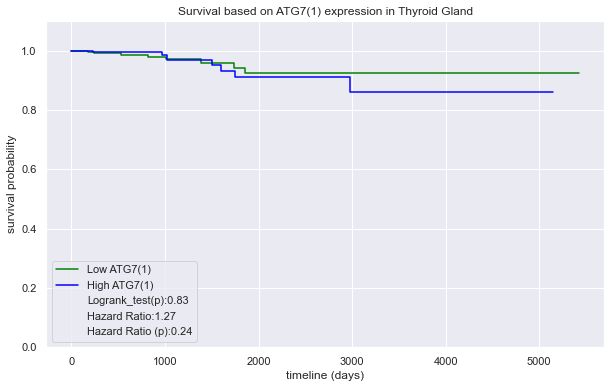

Results for  ATG7(2) in Thyroid Gland


<Figure size 2520x792 with 0 Axes>

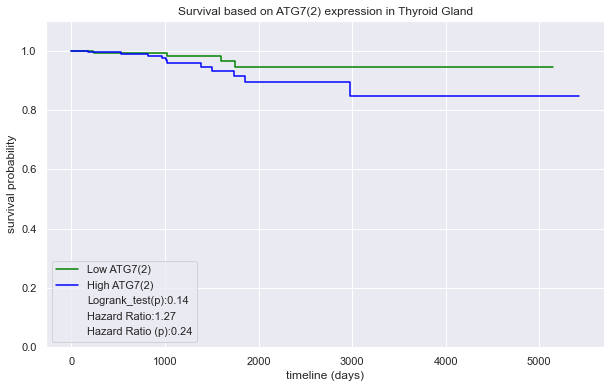

-------------------------------------------------------------------------

For Prostate
Results for  ATG7(total) in Prostate


<Figure size 2520x792 with 0 Axes>

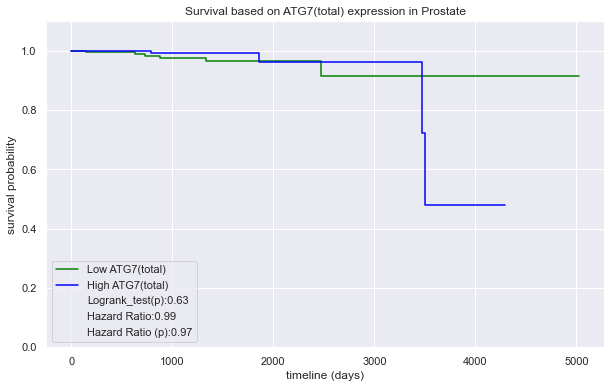

Results for  ATG7(1) in Prostate


<Figure size 2520x792 with 0 Axes>

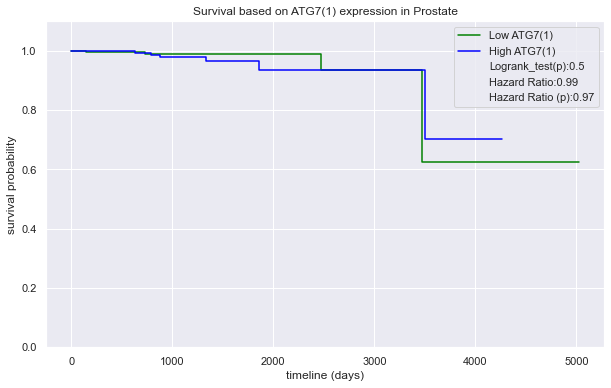

Results for  ATG7(2) in Prostate


<Figure size 2520x792 with 0 Axes>

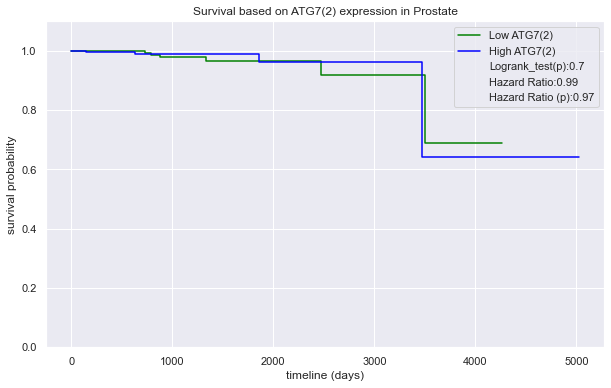

-------------------------------------------------------------------------

For Ovary
Results for  ATG7(total) in Ovary


<Figure size 2520x792 with 0 Axes>

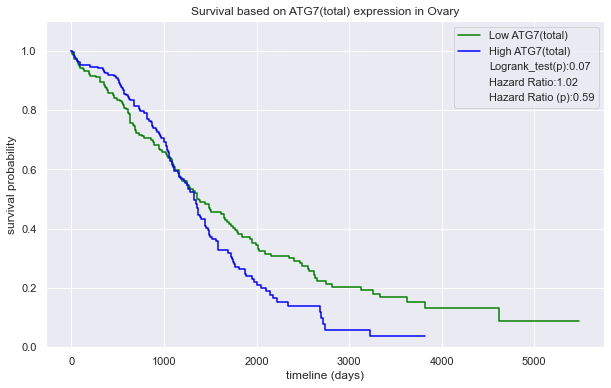

Results for  ATG7(1) in Ovary


<Figure size 2520x792 with 0 Axes>

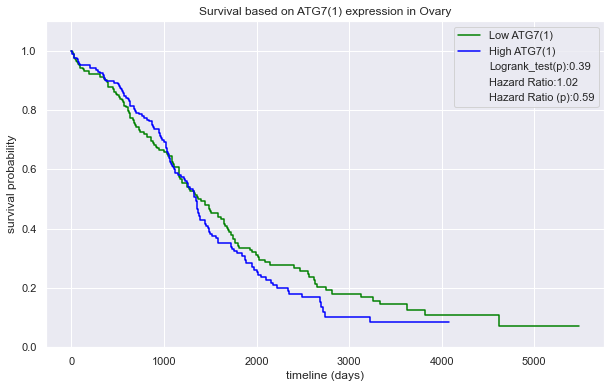

Results for  ATG7(2) in Ovary


<Figure size 2520x792 with 0 Axes>

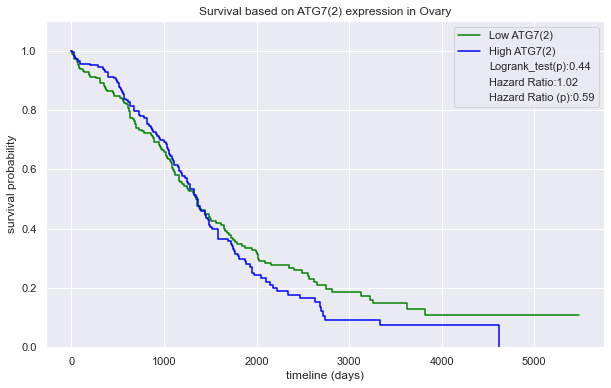

-------------------------------------------------------------------------

For Stomach
Results for  ATG7(total) in Stomach


<Figure size 2520x792 with 0 Axes>

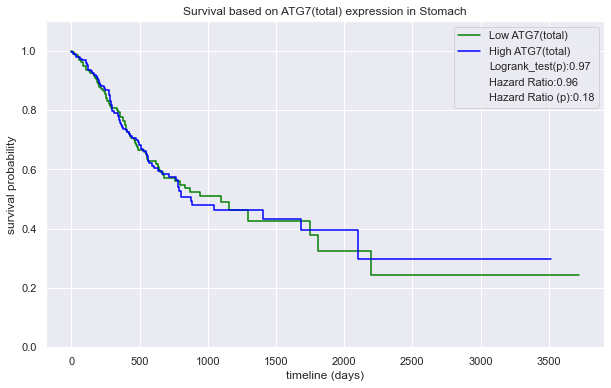

Results for  ATG7(1) in Stomach


<Figure size 2520x792 with 0 Axes>

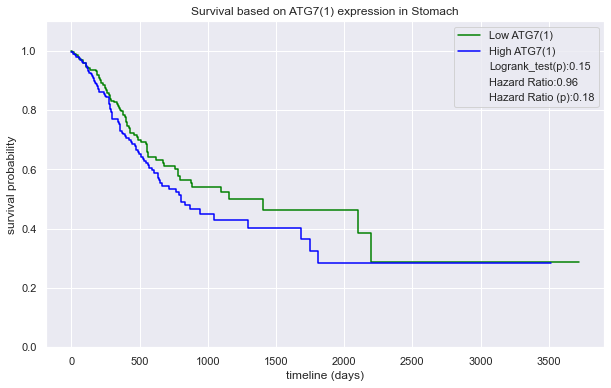

Results for  ATG7(2) in Stomach


<Figure size 2520x792 with 0 Axes>

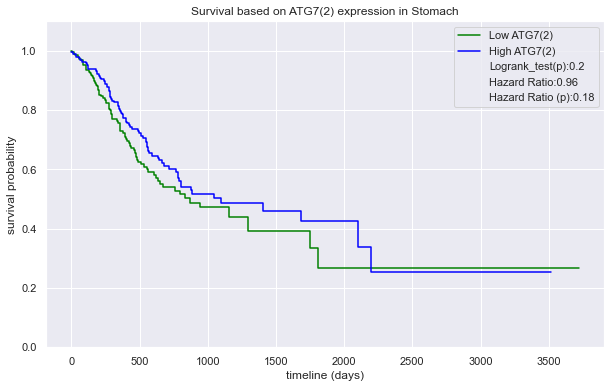

-------------------------------------------------------------------------

For Bladder
Results for  ATG7(total) in Bladder


<Figure size 2520x792 with 0 Axes>

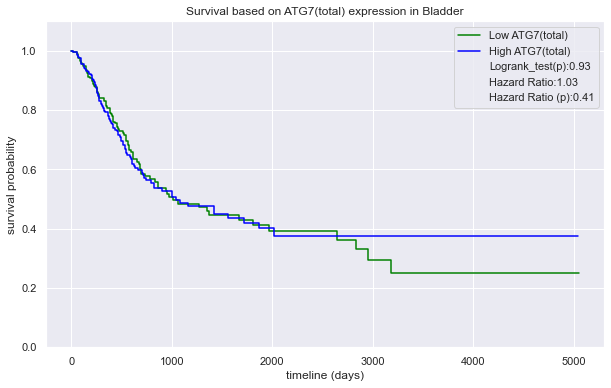

Results for  ATG7(1) in Bladder


<Figure size 2520x792 with 0 Axes>

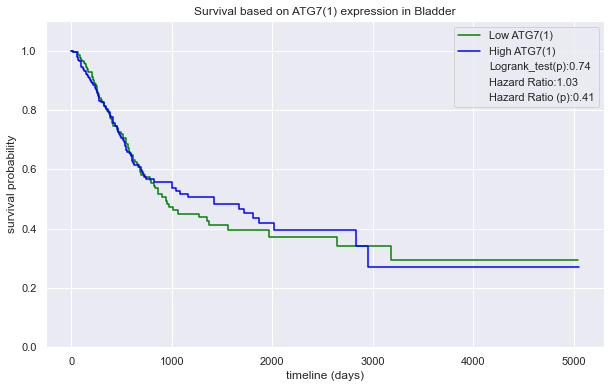

Results for  ATG7(2) in Bladder


<Figure size 2520x792 with 0 Axes>

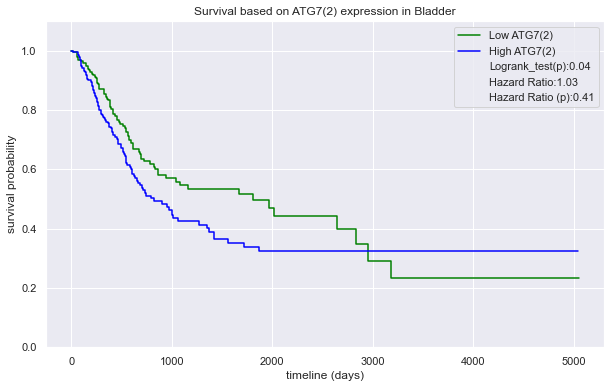

-------------------------------------------------------------------------

For Liver
Results for  ATG7(total) in Liver


<Figure size 2520x792 with 0 Axes>

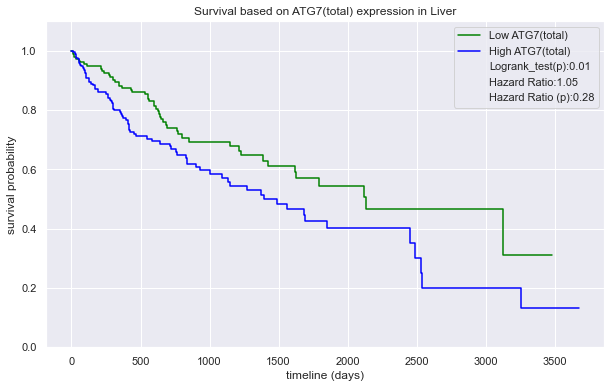

Results for  ATG7(1) in Liver


<Figure size 2520x792 with 0 Axes>

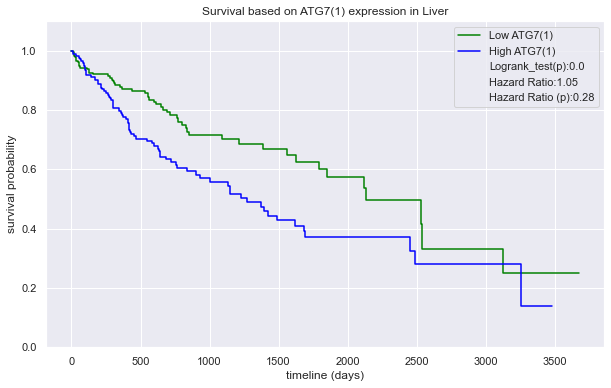

Results for  ATG7(2) in Liver


<Figure size 2520x792 with 0 Axes>

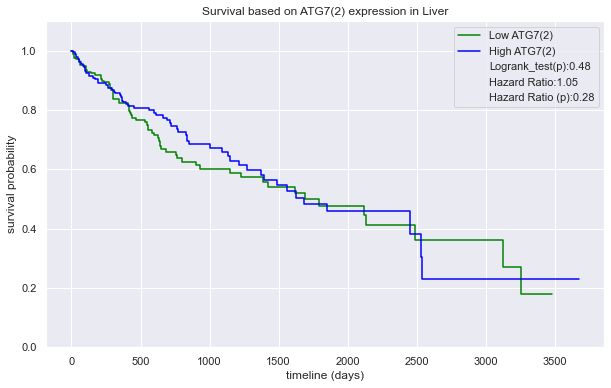

-------------------------------------------------------------------------

For Cervix
Results for  ATG7(total) in Cervix


<Figure size 2520x792 with 0 Axes>

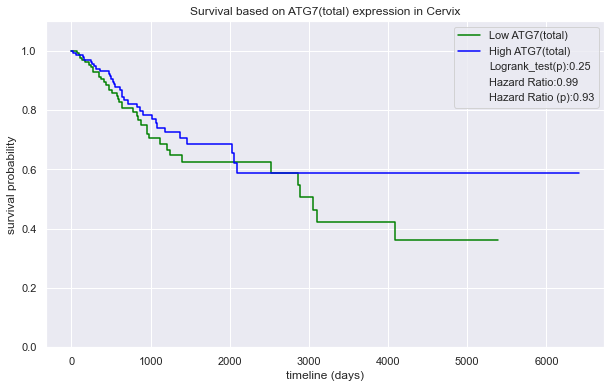

Results for  ATG7(1) in Cervix


<Figure size 2520x792 with 0 Axes>

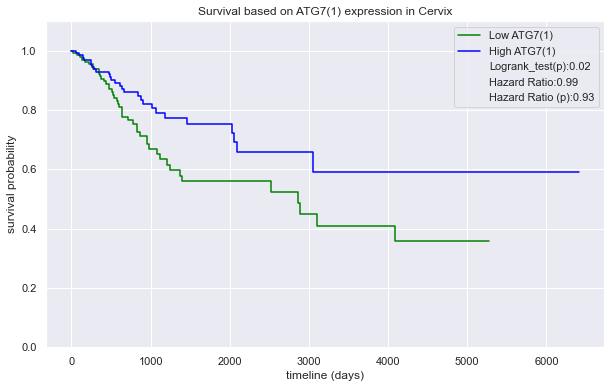

Results for  ATG7(2) in Cervix


<Figure size 2520x792 with 0 Axes>

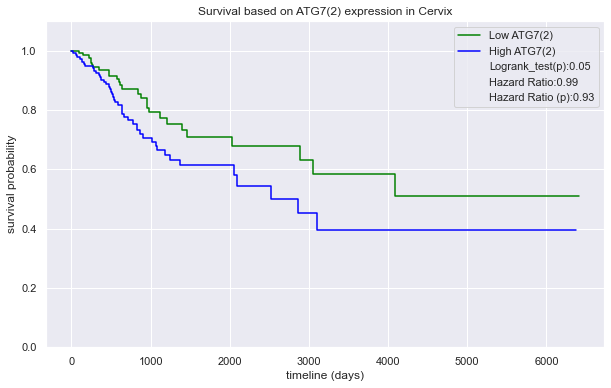

-------------------------------------------------------------------------

For Colon
Results for  ATG7(total) in Colon


<Figure size 2520x792 with 0 Axes>

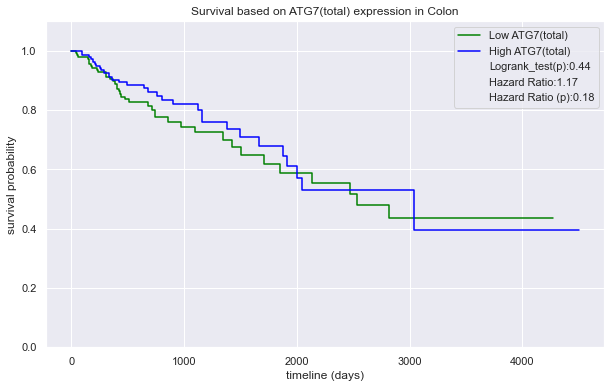

Results for  ATG7(1) in Colon


<Figure size 2520x792 with 0 Axes>

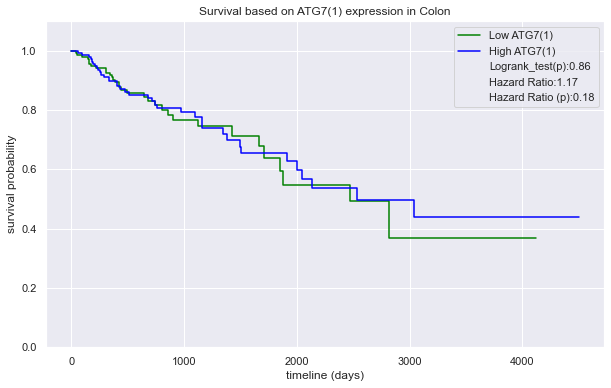

Results for  ATG7(2) in Colon


<Figure size 2520x792 with 0 Axes>

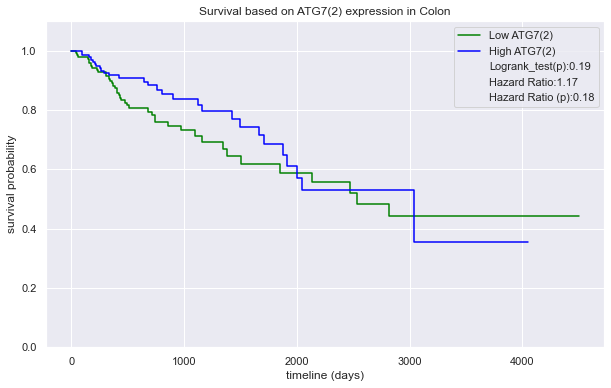

-------------------------------------------------------------------------

For Soft Tissue,Bone
Results for  ATG7(total) in Soft Tissue,Bone


<Figure size 2520x792 with 0 Axes>

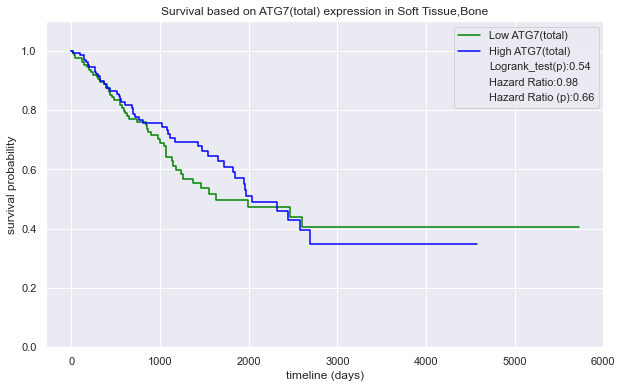

Results for  ATG7(1) in Soft Tissue,Bone


<Figure size 2520x792 with 0 Axes>

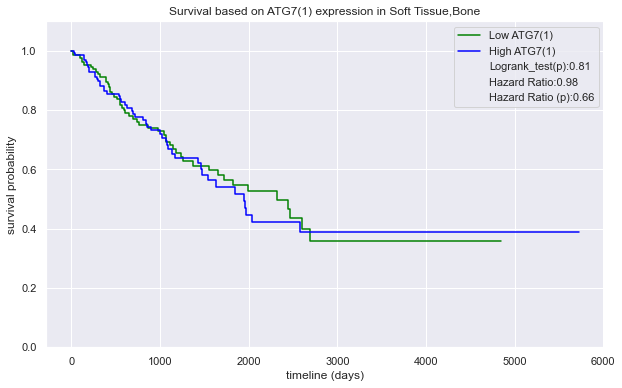

Results for  ATG7(2) in Soft Tissue,Bone


<Figure size 2520x792 with 0 Axes>

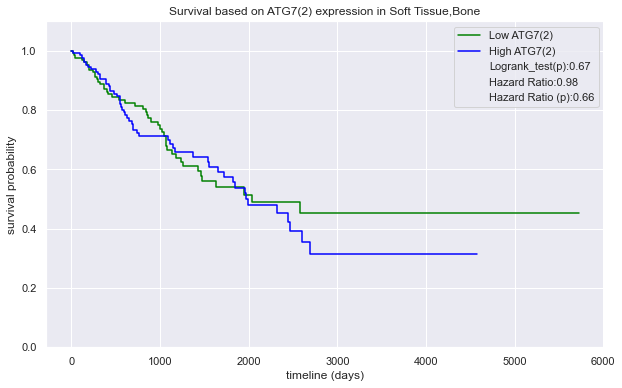

-------------------------------------------------------------------------

For Esophagus
Results for  ATG7(total) in Esophagus


<Figure size 2520x792 with 0 Axes>

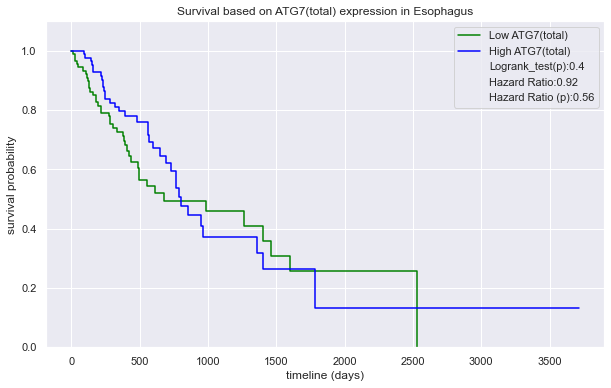

Results for  ATG7(1) in Esophagus


<Figure size 2520x792 with 0 Axes>

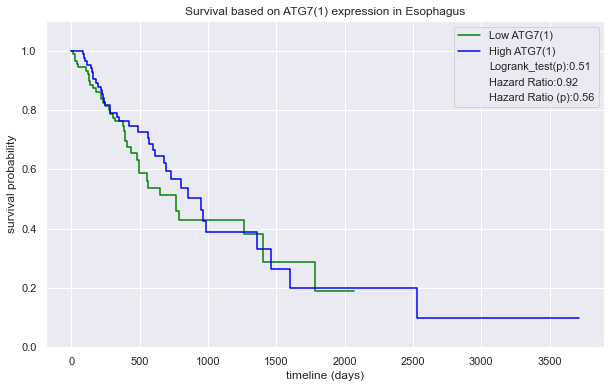

Results for  ATG7(2) in Esophagus


<Figure size 2520x792 with 0 Axes>

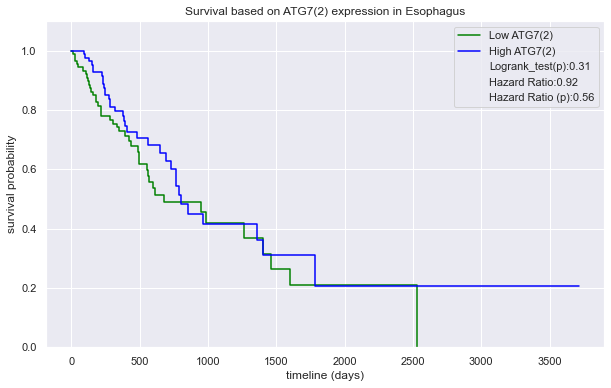

-------------------------------------------------------------------------

For Endometrium
Results for  ATG7(total) in Endometrium


<Figure size 2520x792 with 0 Axes>

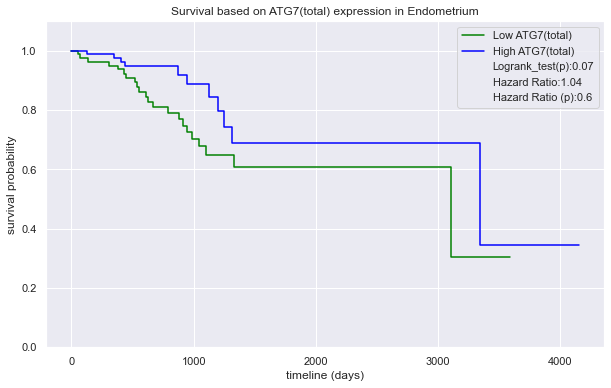

Results for  ATG7(1) in Endometrium


<Figure size 2520x792 with 0 Axes>

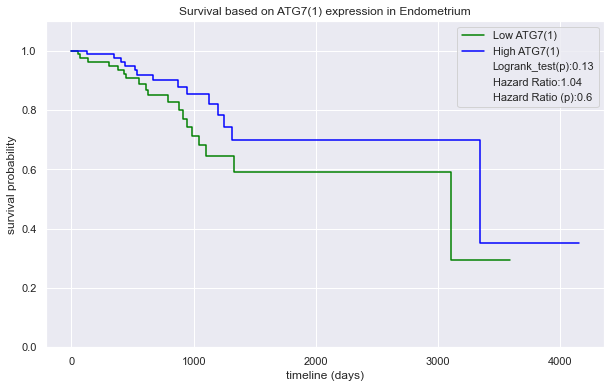

Results for  ATG7(2) in Endometrium


<Figure size 2520x792 with 0 Axes>

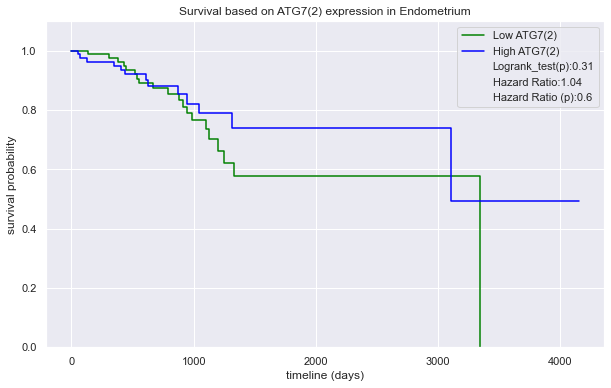

-------------------------------------------------------------------------

For Pancreas
Results for  ATG7(total) in Pancreas


<Figure size 2520x792 with 0 Axes>

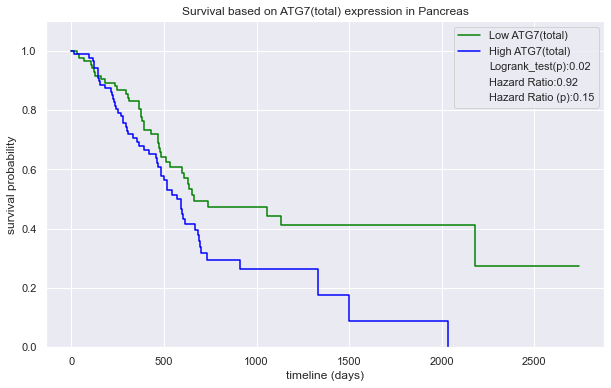

Results for  ATG7(1) in Pancreas


<Figure size 2520x792 with 0 Axes>

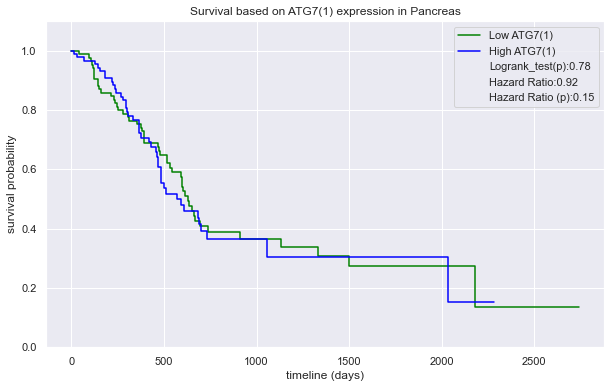

Results for  ATG7(2) in Pancreas


<Figure size 2520x792 with 0 Axes>

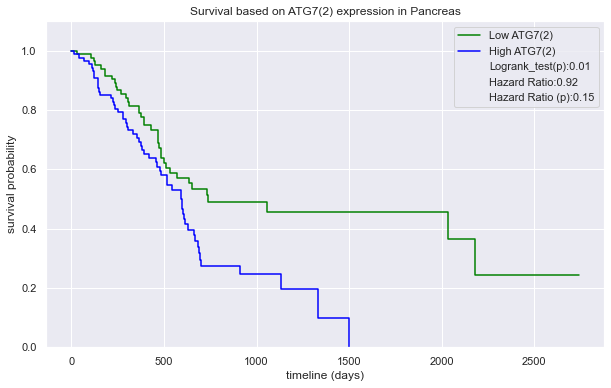

-------------------------------------------------------------------------

For Paraganglia
Results for  ATG7(total) in Paraganglia


<Figure size 2520x792 with 0 Axes>

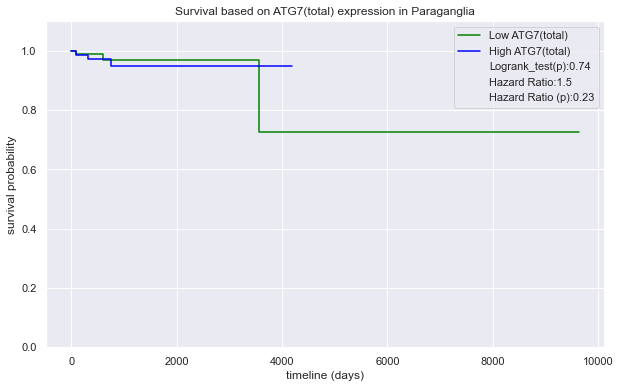

Results for  ATG7(1) in Paraganglia


<Figure size 2520x792 with 0 Axes>

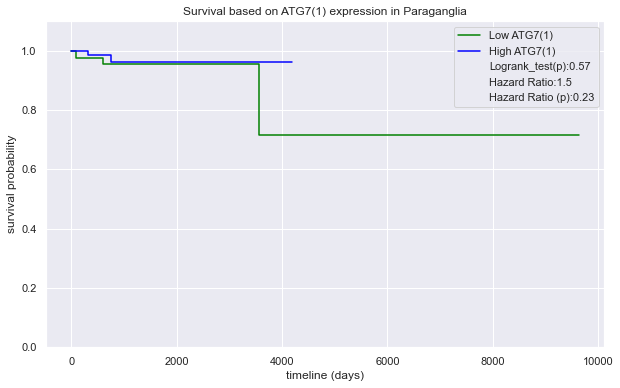

Results for  ATG7(2) in Paraganglia


<Figure size 2520x792 with 0 Axes>

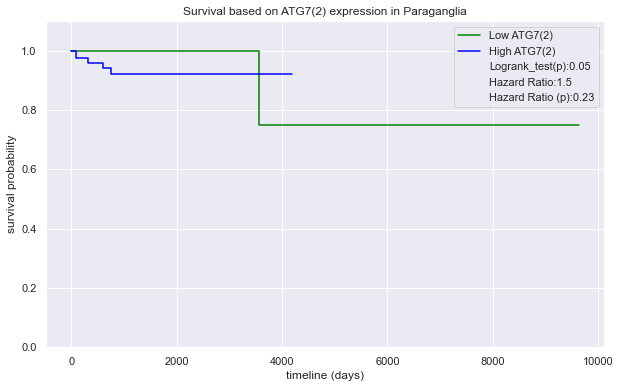

-------------------------------------------------------------------------

For Testis
Results for  ATG7(total) in Testis


<Figure size 2520x792 with 0 Axes>

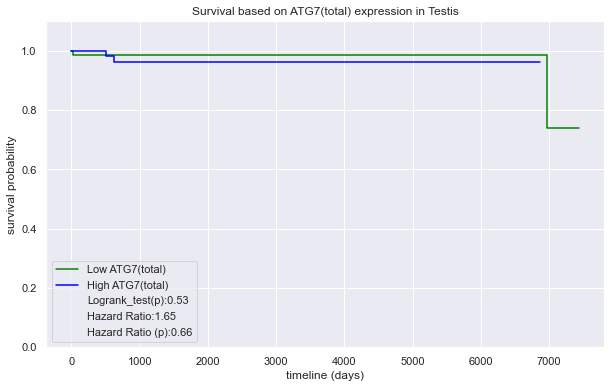

Results for  ATG7(1) in Testis


<Figure size 2520x792 with 0 Axes>

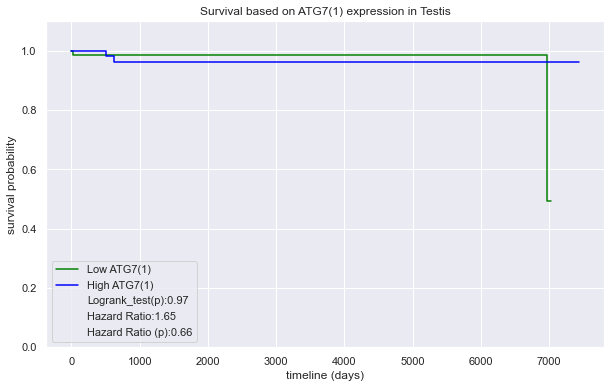

Results for  ATG7(2) in Testis


<Figure size 2520x792 with 0 Axes>

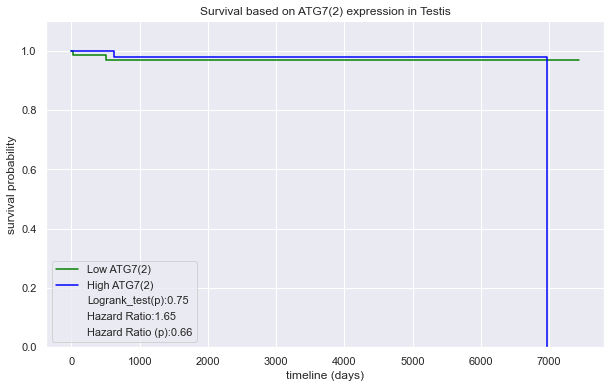

-------------------------------------------------------------------------

For Thymus
Results for  ATG7(total) in Thymus


<Figure size 2520x792 with 0 Axes>

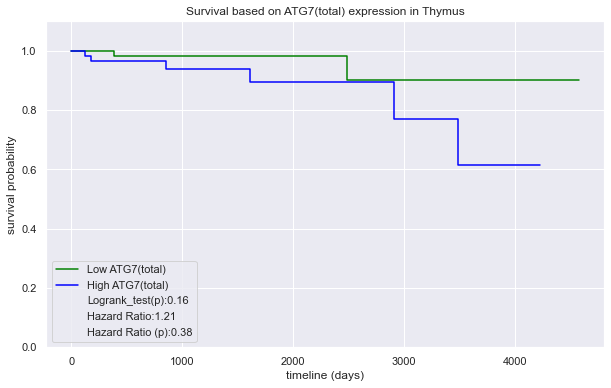

Results for  ATG7(1) in Thymus


<Figure size 2520x792 with 0 Axes>

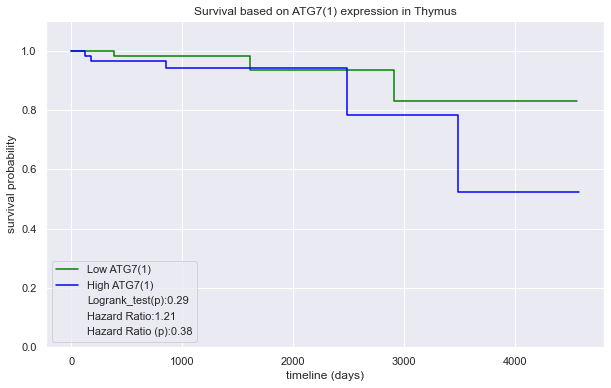

Results for  ATG7(2) in Thymus


<Figure size 2520x792 with 0 Axes>

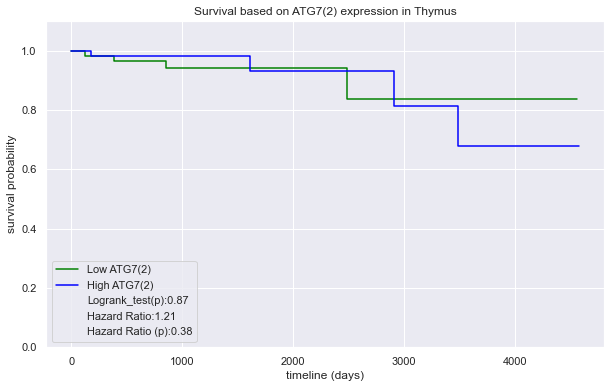

-------------------------------------------------------------------------

For Skin
Results for  ATG7(total) in Skin


<Figure size 2520x792 with 0 Axes>

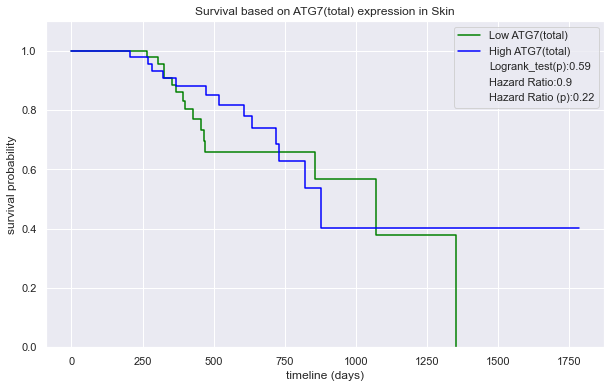

Results for  ATG7(1) in Skin


<Figure size 2520x792 with 0 Axes>

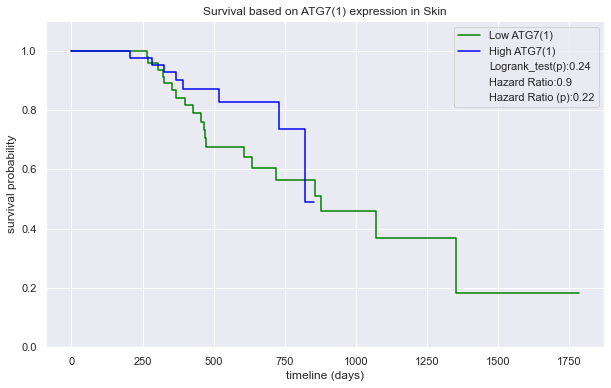

Results for  ATG7(2) in Skin


<Figure size 2520x792 with 0 Axes>

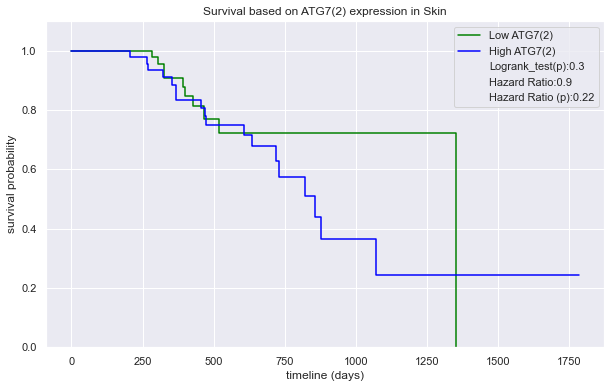

-------------------------------------------------------------------------

For Rectum
Results for  ATG7(total) in Rectum


<Figure size 2520x792 with 0 Axes>

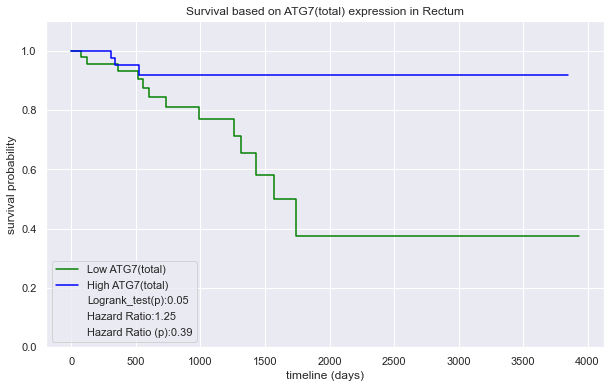

Results for  ATG7(1) in Rectum


<Figure size 2520x792 with 0 Axes>

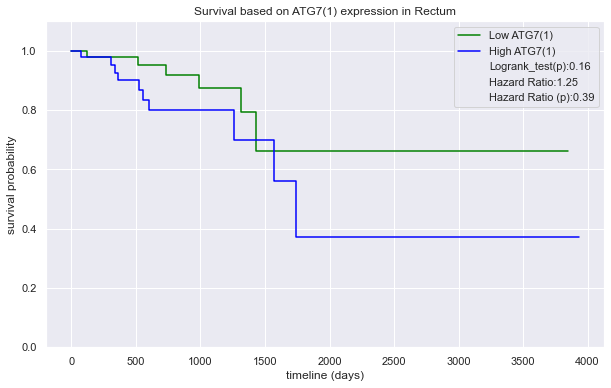

Results for  ATG7(2) in Rectum


<Figure size 2520x792 with 0 Axes>

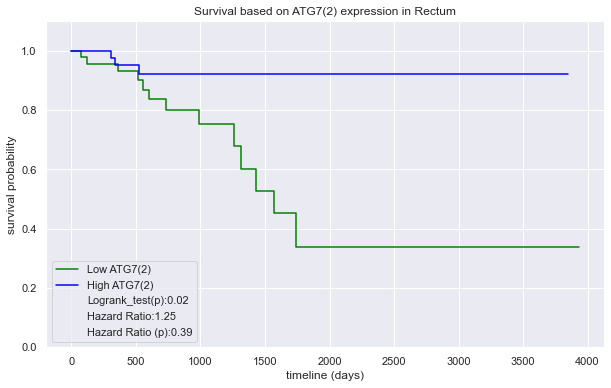

-------------------------------------------------------------------------

For Lining Of Body Cavities
Results for  ATG7(total) in Lining Of Body Cavities


<Figure size 2520x792 with 0 Axes>

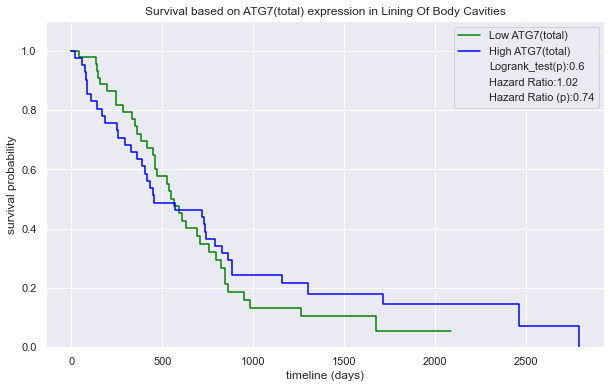

Results for  ATG7(1) in Lining Of Body Cavities


<Figure size 2520x792 with 0 Axes>

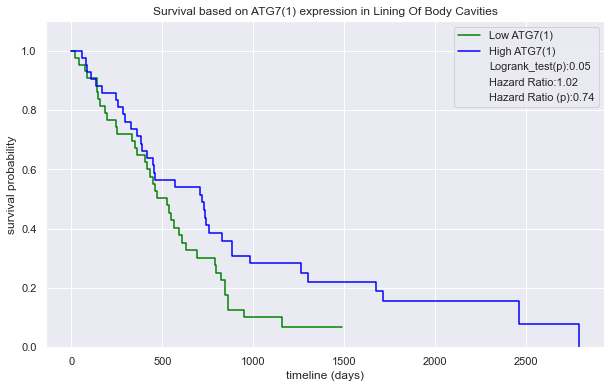

Results for  ATG7(2) in Lining Of Body Cavities


<Figure size 2520x792 with 0 Axes>

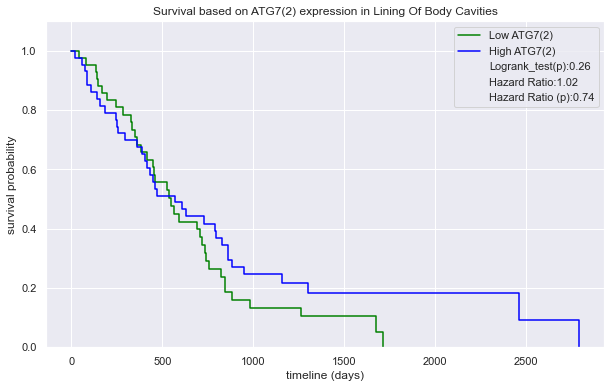

-------------------------------------------------------------------------

For Eye
Results for  ATG7(total) in Eye


<Figure size 2520x792 with 0 Axes>

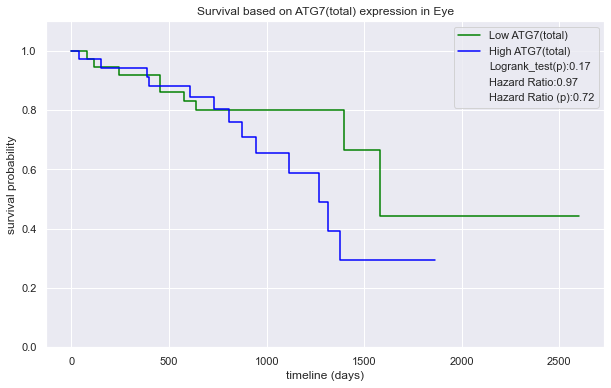

Results for  ATG7(1) in Eye


<Figure size 2520x792 with 0 Axes>

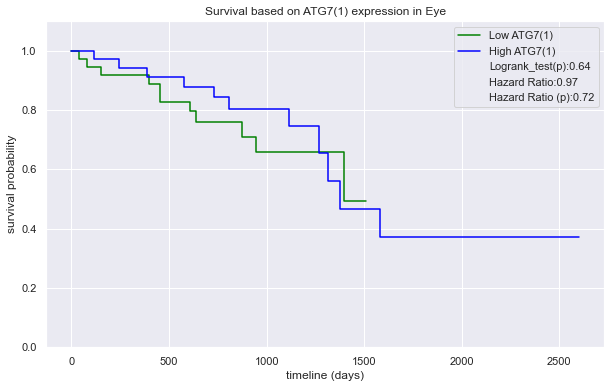

Results for  ATG7(2) in Eye


<Figure size 2520x792 with 0 Axes>

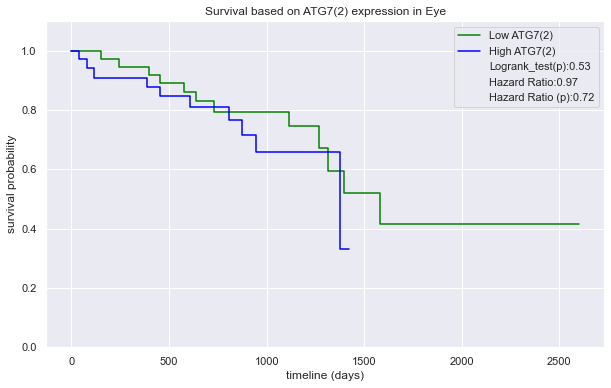

-------------------------------------------------------------------------

For Adrenal Gland
Results for  ATG7(total) in Adrenal Gland


<Figure size 2520x792 with 0 Axes>

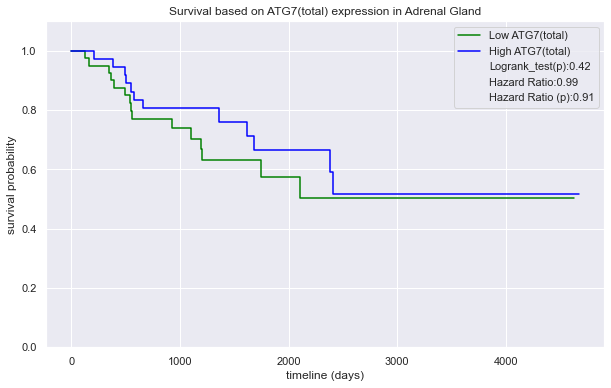

Results for  ATG7(1) in Adrenal Gland


<Figure size 2520x792 with 0 Axes>

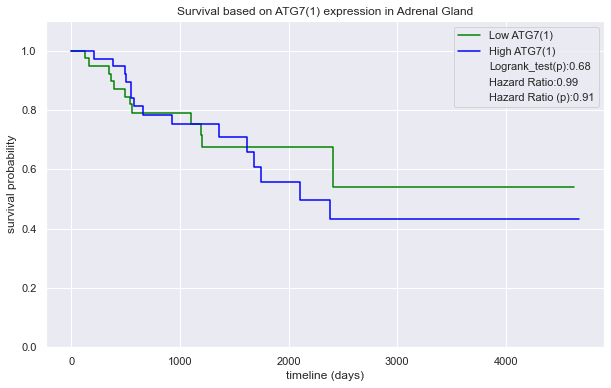

Results for  ATG7(2) in Adrenal Gland


<Figure size 2520x792 with 0 Axes>

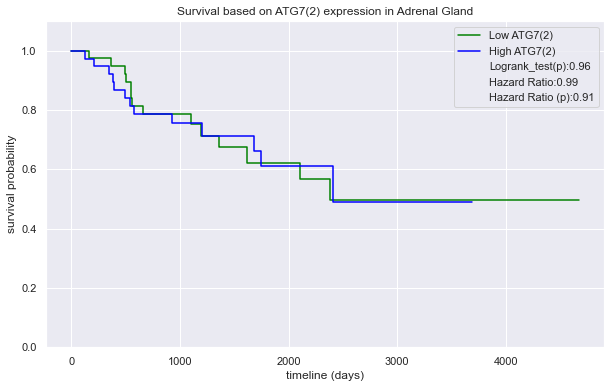

-------------------------------------------------------------------------

For Uterus
Results for  ATG7(total) in Uterus


<Figure size 2520x792 with 0 Axes>

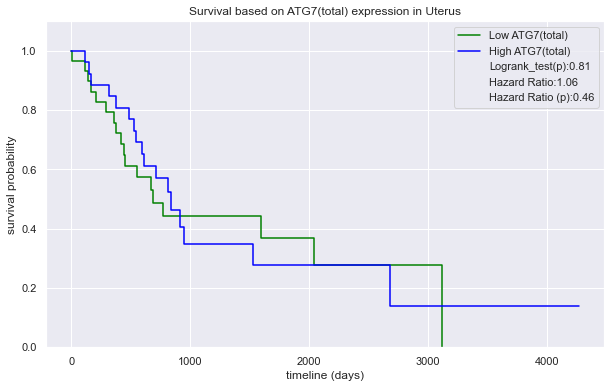

Results for  ATG7(1) in Uterus


<Figure size 2520x792 with 0 Axes>

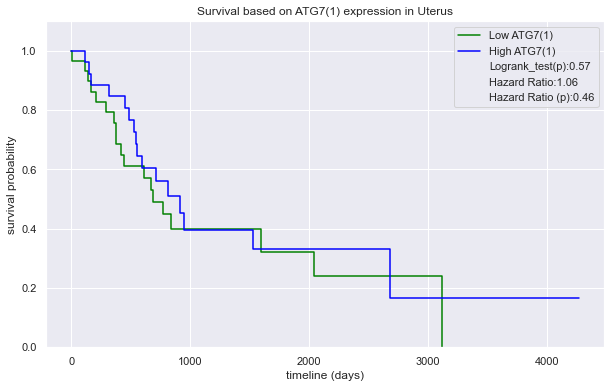

Results for  ATG7(2) in Uterus


<Figure size 2520x792 with 0 Axes>

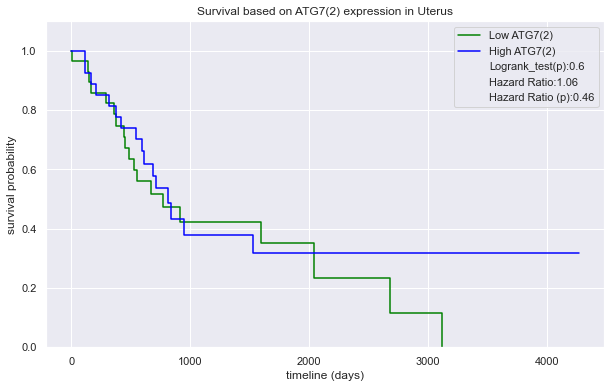

-------------------------------------------------------------------------

For Lymphatic Tissue
Results for  ATG7(total) in Lymphatic Tissue


<Figure size 2520x792 with 0 Axes>

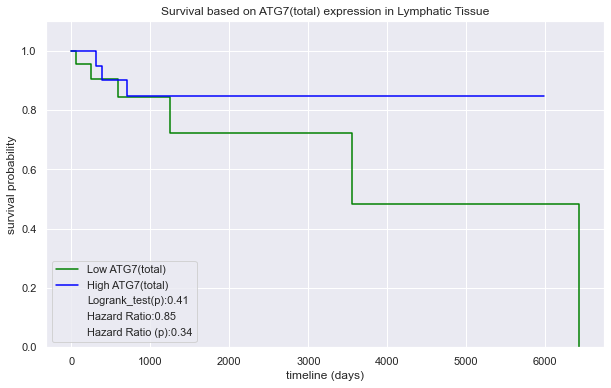

Results for  ATG7(1) in Lymphatic Tissue


<Figure size 2520x792 with 0 Axes>

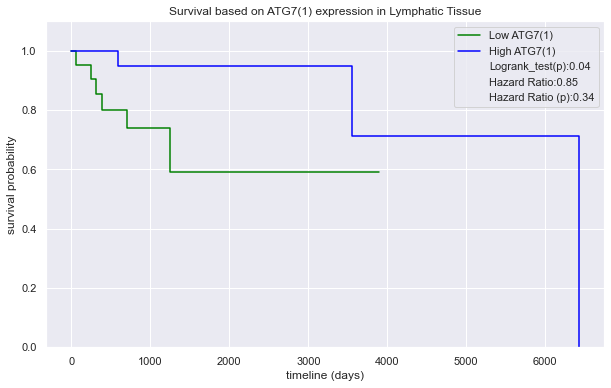

Results for  ATG7(2) in Lymphatic Tissue


<Figure size 2520x792 with 0 Axes>

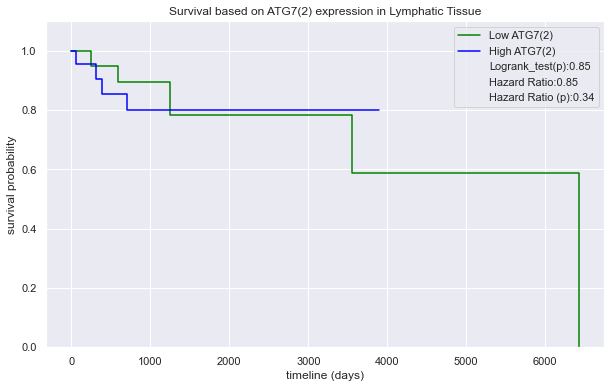

-------------------------------------------------------------------------

For Bile Duct
Results for  ATG7(total) in Bile Duct


<Figure size 2520x792 with 0 Axes>

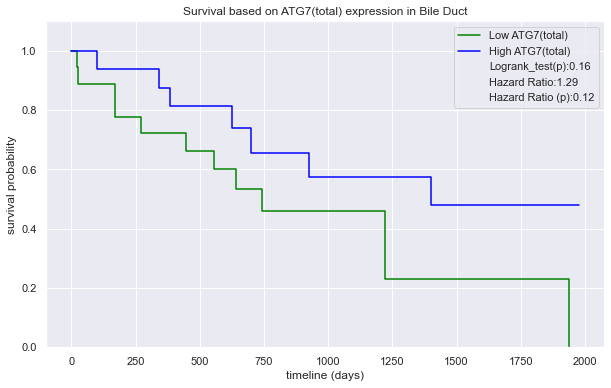

Results for  ATG7(1) in Bile Duct


<Figure size 2520x792 with 0 Axes>

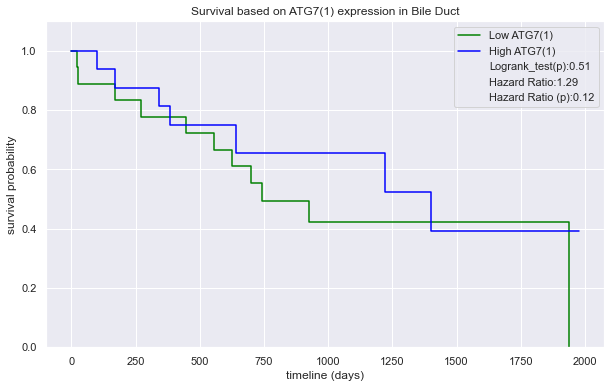

Results for  ATG7(2) in Bile Duct


<Figure size 2520x792 with 0 Axes>

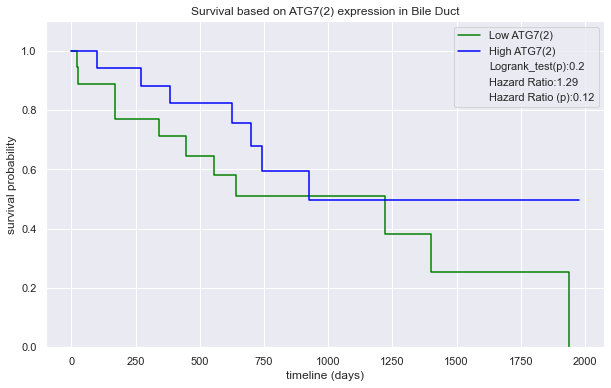

-------------------------------------------------------------------------



<Figure size 2520x792 with 0 Axes>

In [13]:
#Kaplan Meier for all tissues 
isoforms = [["ATG7_total", 'total'], ["ATG7_1", "iso1"], ["ATG7_2", "iso2"]]

#create df_site for each primary site (tissue)
for i in range(len(tissue_labels)):
    tissue = tissue_labels[i]
    print('For', tissue)

    text_site = 'Primary_Site == ' + "'" + tissue + "'"
    df_site = df_ATG7_Prim.query(text_site)
    
    # STATS CoxPHFitter: Does ATG7 expression affect survival ?
    cph = CoxPHFitter()
    df = df_site.iloc[:,3:9]
    cph.fit(df,'OS_time', 'OS')
#     print('CoxPHFitter stats:')
#     cph.print_summary()
    cph_results = cph.summary
    
    #Preparation for Kaplan Meier graph 
    #Split this df_site in two groups of expression
    df_LoHi = [] 
    for isoform in isoforms:
        xMed = df_site[isoform[0]].median()
#         print("For",isoform[0], "median is", xMed)

        #create Low
        text_low =  isoform[0] + '<= ' + str(xMed)
        low = df_site.query(text_low).copy()
        low['L/H'] = "Low_"+isoform[1]
        #move the column
        col = low.pop('L/H')
        low.insert(3, 'L/H', col)

        #create High
        text_high =  isoform[0] + '> ' + str(xMed)
        high = df_site.query(text_high).copy()
        high['L/H'] = "High_"+isoform[1]
        #move the column
        col = high.pop('L/H')
        high.insert(3, 'L/H', col)

        #save
        df_LoHi.append(low)
        df_LoHi.append(high)
    
    #split in two df
    df_total_Low = df_LoHi[0]
    df_total_High = df_LoHi[1]
    df_iso1_Low = df_LoHi[2]
    df_iso1_High = df_LoHi[3]
    df_iso2_Low = df_LoHi[4]
    df_iso2_High = df_LoHi[5]
    
    #recuperation of value (HR and p-value) from CPH 
    cph_results = cph_results[['exp(coef)', 'p']]
    cph_results.reset_index(inplace= True)
    
    cph_atg7 = cph_results.loc[(cph_results['covariate'] == isoform[0])]
    hr_res = str(cph_atg7.loc[cph_atg7.index[0],'exp(coef)'].round(2))
    hr_pvalue_res = str(cph_atg7.loc[cph_atg7.index[0],'p'].round(2))
    
    #Plot the graph and some data
    #Kaplan Meier
    ##Create survival table 
    kmf_low = KaplanMeierFitter() 
    kmf_high = KaplanMeierFitter()
#     print("Survival probability at 6000 days/ 16 years:")
    
    all_data = [["ATG7(total)", df_total_Low, df_total_High],
                ["ATG7(1)", df_iso1_Low, df_iso1_High], 
                ["ATG7(2)", df_iso2_Low, df_iso2_High]]

    tables_kmf = []
    for data in all_data:               
        Time=data[1]['OS_time']
        Event=data[1]['OS']
        Time2=data[2]['OS_time']
        Event2=data[2]['OS']
        
        # STATS_Log-Rank Test: Does ATG7 expression affect survival ?
        results = logrank_test(Time,Time2,event_observed_A=Event, event_observed_B=Event2)
        
        print("Results for ", data[0], 'in', tissue)
#         results.print_summary()
        logrank_summary = results.summary
        logrank_res = str(logrank_summary.loc[logrank_summary.index[0], 'p'].round(2))
       
        #GRAPH_ Kaplan Meier
        ##Low expression
        kmf_low.fit(Time, Event, label = "Low_KM_estim")
#         print("For", data[0], "in low group:",  kmf_low.predict(6000))
        table_kmf_Low = kmf_low.survival_function_
        label1 = "Low "+ data[0]
        ##High expression
        kmf_high.fit(Time2, Event2, label = 'High_KM_estim')    
#         print("For", data[0], "in high group:",  kmf_high.predict(6000))
        table_kmf_High = kmf_high.survival_function_
        label2 = "High "+ data[0]
        
        #save data
        tables_kmf.append(table_kmf_Low)
        tables_kmf.append(table_kmf_High)

        #Plot
        plt.figure(figsize=(10,6))
        seaborn.lineplot(data=table_kmf_Low, x='timeline', y='Low_KM_estim', color = "green", drawstyle='steps-post', label = label1)
        seaborn.lineplot(data=table_kmf_High, x='timeline', y='High_KM_estim', color = "blue", drawstyle='steps-post', label = label2)
        seaborn.regplot(x=[],y=[], marker=" ", label= 'Logrank_test(p):'+ logrank_res)
        seaborn.regplot(x=[],y=[], marker=" ", label= 'Hazard Ratio:'+hr_res)
        seaborn.regplot(x=[],y=[], marker=" ", label= 'Hazard Ratio (p):'+hr_pvalue_res)
        
        plt.legend()
        plt.ylim(0,1.1) 
        plt.xlabel('timeline (days)')
        plt.ylabel('survival probability')

        title_text = "Survival based on "+data[0]+ " expression in "+tissue
        plt.title(title_text)
        plt.show()
        
        #save to csv
        path = 'ATG7/Organ_specific/figs_survival/'
        title_file = tissue+'_primary_kaplan_m_'+data[0]+'.svg'
        plt.savefig(output_file_directory+path+title_file)

    print('-------------------------------------------------------------------------')
    print()
       